<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modelyng_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta



# **Loading data from drive, doing feature selection/transformation**

In [2]:
#importing libs for the model
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:

#independent variables

x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')

# x.columns=x.iloc[0,:]

x.index=x['Date']
x.drop(columns=['Date'], inplace=True)
# x['Mortgage loans'] = np.log(x['Mortgage loans'])
x['Mortgage loans']=np.log(x['Mortgage loans'])

In [4]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

##**List of factors with growth rate**

In [5]:


to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


##Definin factors to remove/combine

In [6]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)

x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)


In [7]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [8]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

# # x.columns=x.iloc[0,:]

y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [9]:
# x.isnull().sum()

In [10]:
x_back=x.copy(deep=True)

In [11]:
y_back=y.copy(deep=True)

In [12]:
# factors=a[a['close'].isnull()==False]
# factors

##Creating seasonal components for the data

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Step 1: Perform Seasonal Decomposition
decomposed = seasonal_decompose(y, period=12, model='additive')
# data['seasonal_component'] = decomposed.seasonal
# data['trend_component'] = decomposed.trend
# data['residual_component'] = decomposed.resid  # The stationary part
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

In [14]:
decomposed = seasonal_decompose(y, period=12, model='additive', extrapolate_trend='freq')
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

In [15]:
y_trend

,trend
Date,
2013-01-01,7.488315
2013-02-01,7.490225
2013-03-01,7.492136
2013-04-01,7.494046
2013-05-01,7.495956
...,...
2024-08-01,7.573851
2024-09-01,7.601497
2024-10-01,7.629143


## **Stationarity adjustments**


In [16]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))


In [17]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [18]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    x[i].fillna(0, inplace = True)
    dict_normalized[i]=check_stationarity(x[i])[2]
    #print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
# dict_normalized

<ipython-input-18-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[i].fillna(0, inplace = True)
<ipython-input-18-5b5da57725ae>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col:

In [19]:
print(len(features))
print(len(levels))
# pd.DataFrame({"name":features, "diff_level":levels})

44
44


In [20]:
type(dict_normalized.std().values)

numpy.ndarray

In [21]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
16,Return on capital,1
41,Dolarisation_avg,1
38,Transport and communications loans (fc),1
37,Others loans,1
36,Mortgage loans,1


In [22]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=7]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>7]
valid_factors

,factor
0,Inflow (trade)
1,Inflow (non-trade)
2,Outflow (trade)
3,Outflow (non-trade)
4,Reserve position in the IMF
5,Foreign Exchange Reserves
6,Government’s net domestic assets (million AMD)
7,Banks’ net domestic assets (million AMD)
8,Net other assets (million AMD)
9,CPI


In [23]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


In [24]:
#defining X and Y

In [25]:
x=dict_normalized
x=x[valid_factors]

In [26]:
#x

In [27]:
y=pd.DataFrame({'Z-score':y})
#y

##**Creating scaled factors**

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled= scaler.fit_transform(x)

In [29]:
X=pd.DataFrame(x_scaled, columns=x.columns.values)
X.index=x.index

## **checking multicolinearity**


In [30]:
Highly_Correlated_column_name = {}
corr = X.corr().to_numpy()
column_names = X.columns
row_no = 0
for r in corr:
    col_no = 0
    for c in r:
        if (c>0.9 and c<1) or (c<-0.9 and c>-1):
            if column_names[row_no] in Highly_Correlated_column_name:
              if column_names[col_no] not in Highly_Correlated_column_name[column_names[row_no]]:
                Highly_Correlated_column_name[column_names[row_no]].append(column_names[col_no])
            else:
              Highly_Correlated_column_name[column_names[row_no]] = [column_names[col_no]]
            print(f"'{column_names[row_no]}', '{column_names[col_no]}', {c}")
        col_no+=1
    row_no += 1

In [31]:
# x.columns.values

In [32]:
# X.isnull().sum()
#X.corr().to_csv('/content/drive/My Drive/Dissertation/adjusted_corr_v3.csv')

In [33]:
data=pd.concat([X,y], axis=1)

In [34]:
data.corr()

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans,Z-score
Inflow (trade),1.000000,0.293460,0.507220,0.208820,-0.014551,0.137261,0.098166,0.138123,0.126441,-0.088357,...,-0.016430,0.333346,0.050402,-0.037776,-0.006857,-0.001425,-0.284902,0.016756,0.034937,0.231497
Inflow (non-trade),0.293460,1.000000,0.258959,0.570080,0.093912,0.382040,0.174809,0.116534,0.167735,-0.236099,...,0.043241,0.558717,0.305590,0.109939,0.159549,0.009872,-0.389460,0.150852,0.253476,0.547856
Outflow (trade),0.507220,0.258959,1.000000,0.192759,0.045906,0.116301,0.105721,-0.027444,0.104754,-0.172617,...,-0.002539,0.235713,0.011811,-0.138326,-0.030578,-0.058775,-0.100586,0.020912,0.083264,0.160852
Outflow (non-trade),0.208820,0.570080,0.192759,1.000000,0.061872,0.334144,-0.036802,0.030590,0.143514,-0.082101,...,0.126577,0.454795,0.161733,0.222676,0.190036,0.014516,-0.231328,0.157967,0.324278,0.479944
Reserve position in the IMF,-0.014551,0.093912,0.045906,0.061872,1.000000,-0.029807,-0.000161,-0.096798,0.060151,-0.002414,...,-0.203081,-0.004083,-0.045441,-0.051957,-0.034987,-0.074320,0.161309,0.133222,0.048049,-0.020050
Foreign Exchange Reserves,0.137261,0.382040,0.116301,0.334144,-0.029807,1.000000,-0.469969,0.170362,0.291970,0.013305,...,0.074968,0.154138,0.277551,0.254990,0.211402,-0.060551,-0.179909,0.382572,0.582302,0.549776
Government’s net domestic assets (million AMD),0.098166,0.174809,0.105721,-0.036802,-0.000161,-0.469969,1.000000,-0.076457,-0.230156,-0.012418,...,-0.052869,0.165265,0.002105,-0.092670,-0.110725,-0.087831,-0.089827,-0.114296,-0.152149,-0.010435
Banks’ net domestic assets (million AMD),0.138123,0.116534,-0.027444,0.030590,-0.096798,0.170362,-0.076457,1.000000,-0.020718,0.113134,...,0.029374,0.043854,-0.000888,0.041758,0.108622,0.118012,-0.112029,0.132873,0.199407,0.347014
Net other assets (million AMD),0.126441,0.167735,0.104754,0.143514,0.060151,0.291970,-0.230156,-0.020718,1.000000,-0.074471,...,0.010749,-0.072912,0.161959,0.251491,0.222996,-0.099578,-0.137596,0.386109,0.460950,0.100154
CPI,-0.088357,-0.236099,-0.172617,-0.082101,-0.002414,0.013305,-0.012418,0.113134,-0.074471,1.000000,...,0.129268,-0.184825,0.072006,0.085026,-0.050316,-0.031690,0.211670,-0.142576,0.059089,-0.171781


#**Implementing XGboost with time series cross validation**

In [35]:
y.index=X.index
z_s=pd.concat([X,y], axis=1)
z=pd.concat([x,y], axis=1)
z.astype(float)

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans,Z-score
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,0.016509,-8.361170e-04,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361,7.521965
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,0.007990,-3.522740e-05,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111,0.429852
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,0.040489,1.274980e-03,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163,-0.614530
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,0.022991,3.834620e-04,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804,-1.349483
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,0.015826,-3.168855e-06,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148,2.562559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,0.023861,3.354004e-04,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544,0.994868
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,0.025566,-4.624434e-07,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969,0.930966
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,0.024482,4.086000e-04,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043,-2.251795


In [36]:
from decimal import Decimal
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [37]:
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

**Defining lagged factors for ridge and lasso models**

In [38]:
x['seasonal']=y_seasonal
x['trend']=y_trend
x['resid']=y_residual

In [39]:
x

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans,seasonal,trend,resid
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361,-1.315219,7.488315,1.348869
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111,-0.199752,7.490225,0.661344
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163,0.231982,7.492136,-0.386830
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804,-0.862817,7.494046,-0.643423
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148,0.104759,7.495956,0.949649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544,-0.101268,7.573851,0.352369
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969,0.531798,7.601497,0.622622
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043,-0.289386,7.629143,-0.835634


In [40]:
import pandas as pd
z_f=pd.concat([x,y], axis=1)

#creating lags of the model
lag_1=z_f.shift(1)
lag_1_cols=[i+'_L1' for i in lag_1.columns.values]
lag_1.columns=lag_1_cols

lag_2=z_f.shift(2)
lag_2_cols=[i+'_L2' for i in lag_2.columns.values]
lag_2.columns=lag_2_cols

lag_3=z_f.shift(3)
lag_3_cols=[i+'_L3' for i in lag_3.columns.values]
lag_3.columns=lag_3_cols

lag_4=z_f.shift(4)
lag_4_cols=[i+'_L4' for i in lag_4.columns.values]
lag_4.columns=lag_4_cols

lag_5=z_f.shift(5)
lag_5_cols=[i+'_L5' for i in lag_5.columns.values]
lag_5.columns=lag_5_cols

lag_6=z_f.shift(6)
lag_6_cols=[i+'_L6' for i in lag_6.columns.values]
lag_6.columns=lag_6_cols

# lag_12=z_f.shift(12)
# lag_12_cols=[i+'_L12' for i in lag_12.columns.values]
# lag_12.columns=lag_12_cols
all_and_lagged_f=pd.concat([z_f,lag_1,lag_2, lag_3, lag_4, lag_5,lag_6],axis=1)  # , lag_12
all_and_lagged_f.columns.values

all_and_lagged_f.dropna(inplace=True)
#added seasonal components as features

# all_and_lagged_f['resid']=y_residual.loc['2014-01-01':]
# all_and_lagged_f['seasonal']=y_seasonal.loc['2014-01-01':]

a=pd.to_datetime(all_and_lagged_f.index)
all_and_lagged_f['month'] =a.month
all_and_lagged_f['quarter'] = a.quarter
all_and_lagged_f['year'] = a.year
all_and_lagged_f['month_sin'] =np.sin(2 * np.pi * all_and_lagged_f['month'] / 12)
all_and_lagged_f['month_cos'] =np.cos(2 * np.pi * all_and_lagged_f['month'] / 12)
#
X_l_f=all_and_lagged_f.drop('Z-score', axis=1)
y_l_f=all_and_lagged_f['Z-score']

In [41]:
all_and_lagged_f

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,fc-loans_L6,seasonal_L6,trend_L6,resid_L6,Z-score_L6,month,quarter,year,month_sin,month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,3458.72,17166.80,3632.35,438.87,74.430231,102.781692,-4115.511973,31584.403920,-354.747889,0.005079,...,891263.687361,-1.315219,7.488315,1.348869,7.521965,7,3,2013,-5.000000e-01,-8.660254e-01
2013-08-01,-5601.93,-3293.20,-10.30,219.83,65.561339,53.665107,-17231.854638,4645.845062,3187.483789,-0.001731,...,25180.900111,-0.199752,7.490225,0.661344,0.429852,8,3,2013,-8.660254e-01,-5.000000e-01
2013-09-01,-1076.74,-7281.29,1164.77,583.09,6.412767,695.390233,-283603.097452,6466.621456,-776.172065,-0.004912,...,-26975.933163,0.231982,7.492136,-0.386830,-0.614530,9,3,2013,-1.000000e+00,-1.836970e-16
2013-10-01,144.74,6133.92,2080.01,513.95,14.120469,-482.507201,215608.046271,-30809.967912,6263.425983,0.004979,...,-5167.004804,-0.862817,7.494046,-0.643423,-1.349483,10,4,2013,-8.660254e-01,5.000000e-01
2013-11-01,2878.01,-10892.08,1149.53,-570.33,1.851640,78.418307,5136.103121,-14867.983638,6420.884612,0.006226,...,15844.272148,0.104759,7.495956,0.949649,2.562559,11,4,2013,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,7065.007195,-0.199752,7.440523,0.745139,2.275984,8,3,2024,-8.660254e-01,-5.000000e-01
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,-2557.207885,0.231982,7.470223,0.096168,-0.187537,9,3,2024,-1.000000e+00,-1.836970e-16
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,-16400.057821,-0.862817,7.452303,-0.017320,-1.226209,10,4,2024,-8.660254e-01,5.000000e-01


In [42]:
from sklearn.model_selection import train_test_split

X_l_train, X_l_test, Y_l_train, Y_l_test = train_test_split(X_l_f,y_l_f, test_size=0.1, random_state=0, shuffle=False)
# Create and train the linear regression model


In [43]:
# import numpy as np
# X_train_mean = X_l_train.mean(axis=0)  # Shape: (n_features,)
# X_train_std = X_l_train.std(axis=0, ddof=1)  # Shape: (n_features,)
# X_train_scaled=(X_l_train-X_train_mean)/X_train_std
# X_test_scaled=(X_l_test-X_train_mean)/X_train_std

# Y_train_mean=np.mean(Y_l_train)
# Y_train_std=np.std(Y_l_train)

# Y_train_scaled=(Y_l_train-Y_train_mean)/Y_train_std
# Y_test_scaled=(Y_l_test-Y_train_mean)/Y_train_std

In [44]:
# X_l_train=X_train_scaled
# X_l_test=X_test_scaled
# Y_l_train=Y_train_scaled
# Y_l_test=Y_test_scaled

In [45]:
X_l_train

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,fc-loans_L6,seasonal_L6,trend_L6,resid_L6,Z-score_L6,month,quarter,year,month_sin,month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,3458.72,17166.80,3632.35,438.87,74.430231,102.781692,-4115.511973,31584.403920,-354.747889,0.005079,...,891263.687361,-1.315219,7.488315,1.348869,7.521965,7,3,2013,-5.000000e-01,-8.660254e-01
2013-08-01,-5601.93,-3293.20,-10.30,219.83,65.561339,53.665107,-17231.854638,4645.845062,3187.483789,-0.001731,...,25180.900111,-0.199752,7.490225,0.661344,0.429852,8,3,2013,-8.660254e-01,-5.000000e-01
2013-09-01,-1076.74,-7281.29,1164.77,583.09,6.412767,695.390233,-283603.097452,6466.621456,-776.172065,-0.004912,...,-26975.933163,0.231982,7.492136,-0.386830,-0.614530,9,3,2013,-1.000000e+00,-1.836970e-16
2013-10-01,144.74,6133.92,2080.01,513.95,14.120469,-482.507201,215608.046271,-30809.967912,6263.425983,0.004979,...,-5167.004804,-0.862817,7.494046,-0.643423,-1.349483,10,4,2013,-8.660254e-01,5.000000e-01
2013-11-01,2878.01,-10892.08,1149.53,-570.33,1.851640,78.418307,5136.103121,-14867.983638,6420.884612,0.006226,...,15844.272148,0.104759,7.495956,0.949649,2.562559,11,4,2013,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,4688.05,-1122.20,-27092.97,-1321.26,8.849717,163.744666,-55971.795133,128675.928565,-6526.609780,0.003181,...,5284.556342,1.851138,7.293832,-0.221699,2.419832,6,2,2023,1.224647e-16,-1.000000e+00
2023-07-01,-21622.39,-4381.10,-26126.52,-1083.43,45.965205,179.409694,-34514.897610,-154906.319761,-7109.000745,0.004825,...,-1573.946115,-1.315219,7.317062,-0.037301,-2.958728,7,3,2023,-5.000000e-01,-8.660254e-01
2023-08-01,57352.47,-3430.98,25680.59,1711.73,1.879760,137.884908,1715.255248,-73969.017650,8247.876745,0.011069,...,6743.334162,-0.199752,7.315825,-0.276751,0.874780,8,3,2023,-8.660254e-01,-5.000000e-01


In [46]:
# print(X_l_train)

In [47]:
#the above model is evaluated based on filtered, lagged variables. First, factors are chosen, then they are lagged, then they are split to train and test, then they are tested

In [48]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score


##Using grid search to find best model

In [49]:

# # Assume x_ls and y_ls are your DataFrame predictors and target
# # Create a pipeline that standardizes data and then fits an XGBoost model
# pipeline = Pipeline([
#     ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
# ])

# # Define the parameter grid for XGBoost hyperparameters
# param_grid = {
#     'xgb__n_estimators': [50, 75, 100, 300, 500],
#     'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2],
#     'xgb__max_depth': [3, 5, 7],
#     'xgb__subsample': [0.7, 0.8, 1.0],
#     'xgb__colsample_bytree': [0.7, 0.8, 1.0],
#     'xgb__gamma': [0, 0.1, 0.2]
# }

# # Use TimeSeriesSplit for time-aware cross-validation
# tscv = TimeSeriesSplit(n_splits=5)

# # Set up GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='r2', n_jobs=-1, verbose=2)

# # Fit grid search on the data
# grid_search.fit(X_l_train,Y_l_train)

# # Output best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best R² Score:", grid_search.best_score_)

# # Use the best estimator to make predictions and evaluate performance
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_l_test)
# final_r2 = r2_score(Y_l_test, y_pred)
# print(f"Final Model R² Score: {final_r2:.4f}")

# # Calculate RMSE


In [50]:
# Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 0.7}
# Best R² Score: 0.652467270507529
# Final Model R² Score: 0.8479

##evaluatng model based on the best params

In [51]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
 n_estimators=500,           # Number of boosting rounds
    max_depth=3,                # Depth of each tree
    min_child_weight=3,         # Minimum sum of instance weight in a child

    # Learning process
    learning_rate=0.01,         # Lower is safer for time series
    gamma=0.1,                  #
    colsample_bytree=1,
    subsample= 0.7
    )

best_model.fit(X_l_train, Y_l_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [52]:
y_pred = best_model.predict(X_l_test)
final_r2 = r2_score(Y_l_test, y_pred)
print(f"Final Model R² Score: {final_r2:.4f}")

Final Model R² Score: 0.8608


In [53]:
len(X_l_train.columns.values)

340

In [54]:
qmse = mean_squared_error(Y_l_test, y_pred)
rmse = np.sqrt(qmse)
print(f"Final Model rmse: {rmse:.4f}")

Final Model rmse: 0.5677


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(Y_l_test, y_pred)
mse = mean_squared_error(Y_l_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_l_test, y_pred)
print('Forecast Accuracy Metrics:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Forecast Accuracy Metrics:
MAE: 0.4020660628459045
MSE: 0.3222637518864025
RMSE: 0.5676827916067233
MAPE: 0.43678228090768484


In [56]:
import pandas as pd

In [57]:
y_pred=pd.DataFrame(y_pred, index=Y_l_test.index)

In [58]:
len

<function len(obj, /)>

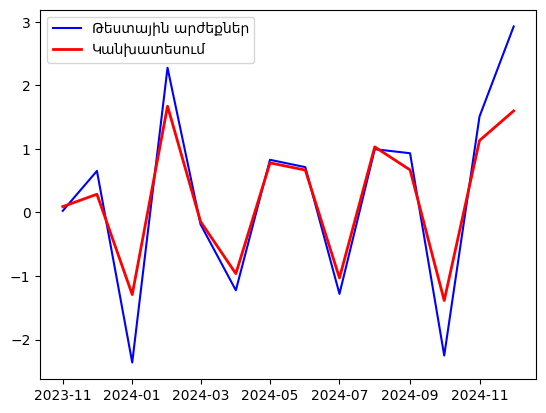

In [59]:
plt.plot(Y_l_test, color='blue', label='Թեստային արժեքներ')
plt.plot(y_pred, color='red', linewidth=2, label='Կանխատեսում')
plt.legend()
plt.show()

In [60]:
#when taking selected features with ridge and lasso, and adjust model on train data, ot gives MSA
#Final Model RMSE: 1.1082
#when evaluating the same model but based on full dataset, the prediction error is less: 0.1673

##Getting importance scores per factor

Top Features:
 Mortgage loans                                        0.054126
Outflow (non-trade)                                   0.039716
seasonal                                              0.031399
Euro/AMD_L4                                           0.022090
High liquidity assets ratio to total assets_L4        0.021653
                                                        ...   
Return on capital_L5                                  0.000000
Normative capital ratio to risk-weighted assets_L5    0.000000
Transport and communications loans (fc)_L2            0.000000
Mortgage loans (fc)_L2                                0.000000
US Dollar/AMD_L4                                      0.000000
Length: 340, dtype: float32


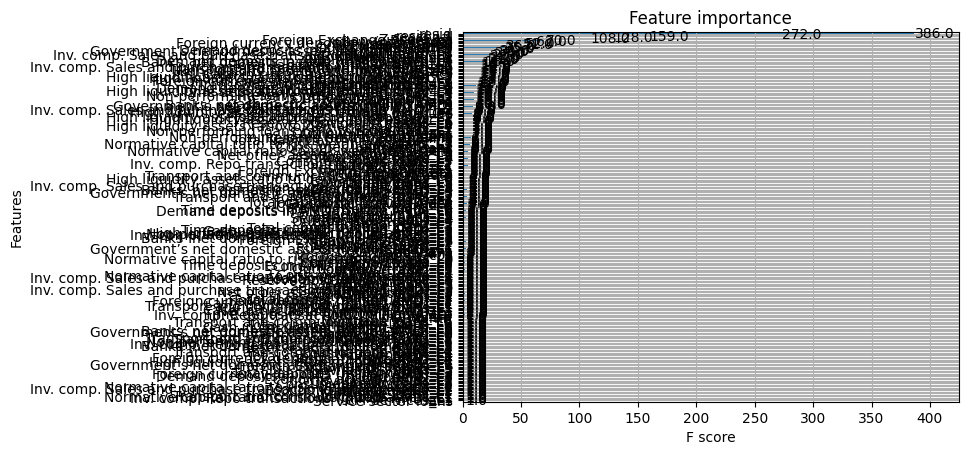

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract trained XGBoost model from pipeline
xgb_model = best_model

# Get feature importance scores
feature_importance = pd.Series(xgb_model.feature_importances_, index=X_l_train.columns)

# Sort features by importance
feature_importance = feature_importance.sort_values(ascending=False)

# Print top features
print("Top Features:\n", feature_importance)

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()


In [62]:
feature_importance.tail(50)

,0
Demand deposits in AMD (million AMD)_L2,0.0
Cash in circulation (million AMD)_L4,0.0
Inflow (trade)_L3,0.0
resid_L4,0.0
seasonal_L4,0.0
bitcoin_price_L4,0.0
Mortgage loans (fc)_L4,0.0
Transport and communications loans (fc)_L4,0.0
bitcoin_price,0.0
Industry Loans_L4,0.0


In [63]:
feature_importance

,0
Mortgage loans,0.054126
Outflow (non-trade),0.039716
seasonal,0.031399
Euro/AMD_L4,0.022090
High liquidity assets ratio to total assets_L4,0.021653
...,...
Return on capital_L5,0.000000
Normative capital ratio to risk-weighted assets_L5,0.000000
Transport and communications loans (fc)_L2,0.000000
Mortgage loans (fc)_L2,0.000000


In [64]:
# pip install shap


In [65]:
X_l_test.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [66]:
x_test_r=X_l_test.rename(
{
'resid':'Մնացորդ',
'seasonal':'Սեզոնային բաղադրիչ',
'resid_L1':'Մնացորդ_L1',
'Z-score_L1':'Z-score_L1',
'seasonal_L6':'Սեզոնային բաղադրիչ_L6',
'Foreign currency deposits (million AMD)':'Արտարժութային ավանդներ',
'Foreign Exchange Reserves':'Արտարժութային պահուստներ',
'Inflow (non-trade)':'Դրամական փոխանցումների ոչ առևտրային ներհոսք',
'Mortgage loans':'Հիպոթեքային վարկեր',
'Demand deposits in AMD (million AMD)':'Ցպահանջ ավանդներ',
'seasonal_L1':'Սեզոնային բաղադրիչ_L1',
'Outflow (non-trade)':'Արտահոսք  ոչ առևտրային ',
'Banks’ net domestic assets (million AMD)_L1':'Բանկային զուտ ներքին ակտիվներ_L1',
'Inflow (trade)_L1':'Դրամական փոխանցումների առևտրային ներհոսք_L1',
'Outflow (non-trade)_L2':'Դրամական փոխանցումների ոչ առևտրային արտահոսք_L2',
'Dolarisation_avg_L4':'Դոլարայնացում_L4',
'seasonal_L3':'Սեզոնային բաղադրիչ_L3',
'Inflow (non-trade)_L1':'Դրամական փոխանցումների ոչ առևտրային ներհոսք_L1',
'Transport and communications loans':'Տրանսպորտի և հաղորդակցության վարկեր',
'Government’s net domestic assets (million AMD)_L2':'Կառավարության զուտ ներքին ակտիվներ_L2',
'Inv. comp. Sales and purchase transactions (million AMD)_L6':'Ներդրումային ընկերությունների առք վաճառքի գործարքներ_L6'


}, axis=1
)


##Getting feature importance using shap values

In [67]:
import shap

# Create the SHAP explainer
explainer = shap.Explainer(best_model, x_test_r)

# Calculate SHAP values for the test set
shap_values = explainer(x_test_r)
shap_values

.values =
array([[-0.00603652, -0.00628355, -0.00197205, ...,  0.        ,
         0.        ,  0.00518277],
       [ 0.00172743,  0.00054511, -0.002037  , ...,  0.        ,
         0.00055986,  0.00123657],
       [-0.00688737, -0.00061074,  0.00162214, ...,  0.        ,
         0.        ,  0.00082438],
       ...,
       [ 0.00509356,  0.00049686,  0.00444096, ...,  0.        ,
        -0.00054792,  0.00210825],
       [-0.0027548 ,  0.00033473, -0.00034714, ...,  0.        ,
         0.        ,  0.00123657],
       [ 0.00164307,  0.00037623,  0.        , ...,  0.        ,
         0.        ,  0.00123657]])

.base_values =
array([0.22171627, 0.22171627, 0.22171627, 0.22171627, 0.22171627,
       0.22171627, 0.22171627, 0.22171627, 0.22171627, 0.22171627,
       0.22171627, 0.22171627, 0.22171627, 0.22171627])

.data =
array([[-4.86813800e+04, -4.80914000e+03, -1.72057000e+04, ...,
         2.02300000e+03, -5.00000000e-01,  8.66025404e-01],
       [ 2.08100000e+04,  6.07372000e+

In [68]:
shap_values[13].values

array([ 1.64306781e-03,  3.76231045e-04,  0.00000000e+00, -1.77964906e-03,
        2.23036009e-03,  6.22911788e-02,  2.65133849e-03,  7.20658548e-03,
        5.39748614e-03,  8.41848051e-03,  2.74319150e-03,  3.09629698e-04,
        6.10911732e-03, -3.02958435e-04,  7.37836077e-04, -8.73293944e-05,
        7.31758757e-04,  7.99004720e-04,  4.04362743e-03,  1.68941221e-02,
       -1.24157859e-03,  0.00000000e+00,  6.96827137e-03,  3.95115571e-02,
        0.00000000e+00, -5.67404212e-02,  8.31948211e-04,  3.14899837e-03,
       -7.58500753e-04,  1.29003577e-03, -2.33258232e-03, -4.00257351e-03,
        2.25023456e-02, -9.15703276e-04,  0.00000000e+00,  3.72076108e-04,
        5.68029396e-03, -1.11231806e-03,  3.79903913e-03,  9.55100107e-04,
        0.00000000e+00,  4.63442777e-04, -9.45101538e-04,  4.28136513e-05,
        3.62145545e-01,  0.00000000e+00,  7.78147869e-01,  2.01709306e-02,
        1.20853078e-02,  0.00000000e+00, -6.88990279e-03,  0.00000000e+00,
        1.08420891e-03,  

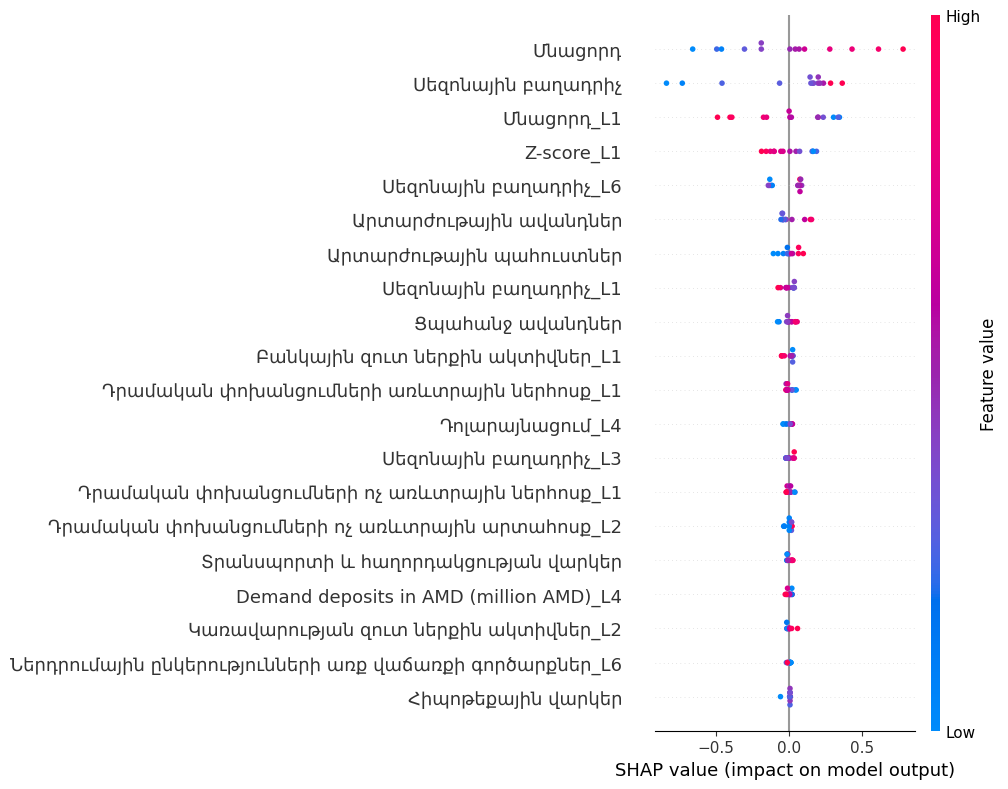

In [69]:
import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Adjust width & height as needed
shap.summary_plot(shap_values, x_test_r, plot_size=(10, 8))  # This sets internal SHAP plot size
